In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import os
import sys
from mne.datasets import eegbci
import glob
from IPython.display import clear_output
import numpy as np
import torch
from torch import nn
import torch.optim as optim

from mne.datasets import eegbci
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from scipy import signal

import torch
import torch.cuda as cuda
import torch.nn as nn
from torch.autograd import Variable

In [2]:
class EEG:
    def __init__(self, path, base_url, subjects, runs):
        self.subpath = '/datasets'
        self.path = path
        self.base_url = base_url
        self.subjects = subjects
        self.runs = runs
        
        # download data if does not exist in path.
        # self.load_data()
        self.data_to_raw()
    
    def load_data(self):
        print(f">>> Start download from: {self.base_url}.")
        print(f"Downloading files to: {self.path}.")
        for subject in self.subjects:
            eegbci.load_data(subject,self.runs,path=self.path,base_url=self.base_url)
        print("Done.")
    
    def data_to_raw(self):
        fullpath = os.path.join(self.path, *self.subpath.split(sep='/'))
        print(f">>> Extract all subjects from: {fullpath}.")
        extension = "edf"
        raws = []
        count = 1
        for i, subject in enumerate(self.subjects):
            sname = f"S{str(subject).zfill(3)}".upper()
            for j, run in enumerate(self.runs):
                rname = f"{sname}R{str(run).zfill(2)}".upper()
                path_file = os.path.join(fullpath, sname, f'{rname}.{extension}')
                print(f"Loading file #{count}/{len(self.subjects)*len(self.runs)}: {f'{rname}.{extension}'}")
                raw = mne.io.read_raw_edf( path_file , preload=True, verbose='WARNING' )
                raws.append(raw)
                count += 1

        raw = mne.io.concatenate_raws(raws)
        eegbci.standardize(raw)
        montage = mne.channels.make_standard_montage('standard_1005')
        raw.set_montage(montage)
        self.raw = raw
        
        print("Done.")
        return self.raw
    def filter(self, freq):
        raw = self.raw
        low, high = freq
        print(f">>> Apply filter.")
        self.raw.filter(low, high, fir_design='firwin', verbose=20)
        return  raw
    def raw_ica(self):
        raw = self.raw
        ica = mne.preprocessing.ICA(n_components=64, max_iter=100)
        ica.fit(raw)
        ica.exclude = [1, 2,3]  # details on how we picked these are omitted here
        ica.plot_properties(raw, picks=ica.exclude)
        ica.apply(raw)
        print('ICA DONE ????')
        return  raw
        
    def get_events(self):
        event_id = dict(T1=0, T2=1) # the events we want to extract
        events, event_id = mne.events_from_annotations(self.raw, event_id=event_id)
        return events, event_id
    
    def get_epochs(self, events, event_id):
        picks = mne.pick_types(self.raw.info, eeg=True, exclude='bads')
        tmin = 0
        tmax = 4
        epochs = mne.Epochs(self.raw, events, event_id, tmin, tmax, proj=True, 
                            picks=picks, baseline=None, preload=True)
        return epochs
    
    def create_epochs(self):
        print(">>> Create Epochs.")
        events, event_id = self.get_events()
        self.epochs = self.get_epochs(events, event_id)
        return events , event_id
        
        print("Done.")
    
    def get_X_y(self):
        if self.epochs is None:
            events , event_id=self.create_epochs()
        self.X = self.epochs.get_data()
        self.y = self.epochs.events[:, -1]
        return self.X, self.y
def do_plot(train_loss, valid_loss):
    plt.figure(figsize=(10,10))
    clear_output(wait=True)
    plt.plot(train_loss, label='train_loss')
    plt.plot(valid_loss, label='valid_loss')
    plt.title('loss {}'.format(iter))
    plt.legend()
    plt.show()



>>> Extract all subjects from: datasets.
Loading file #1/60: S001R03.edf
Loading file #2/60: S001R04.edf
Loading file #3/60: S001R07.edf
Loading file #4/60: S001R08.edf
Loading file #5/60: S001R11.edf
Loading file #6/60: S001R12.edf
Loading file #7/60: S002R03.edf
Loading file #8/60: S002R04.edf
Loading file #9/60: S002R07.edf
Loading file #10/60: S002R08.edf
Loading file #11/60: S002R11.edf
Loading file #12/60: S002R12.edf
Loading file #13/60: S003R03.edf
Loading file #14/60: S003R04.edf
Loading file #15/60: S003R07.edf
Loading file #16/60: S003R08.edf
Loading file #17/60: S003R11.edf
Loading file #18/60: S003R12.edf
Loading file #19/60: S004R03.edf
Loading file #20/60: S004R04.edf
Loading file #21/60: S004R07.edf
Loading file #22/60: S004R08.edf
Loading file #23/60: S004R11.edf
Loading file #24/60: S004R12.edf
Loading file #25/60: S005R03.edf
Loading file #26/60: S005R04.edf
Loading file #27/60: S005R07.edf
Loading file #28/60: S005R08.edf
Loading file #29/60: S005R11.edf
Loading fil

/opt/conda/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Fitting ICA took 272.3s.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
3678 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
3678 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
3678 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


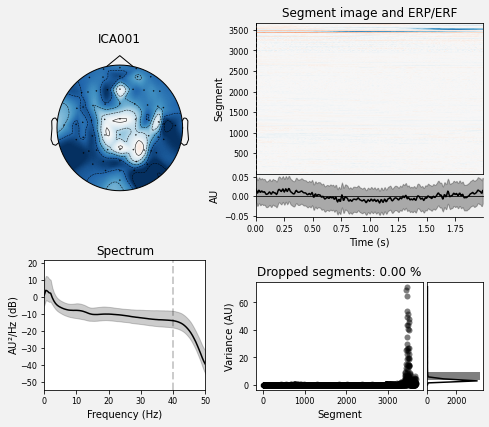

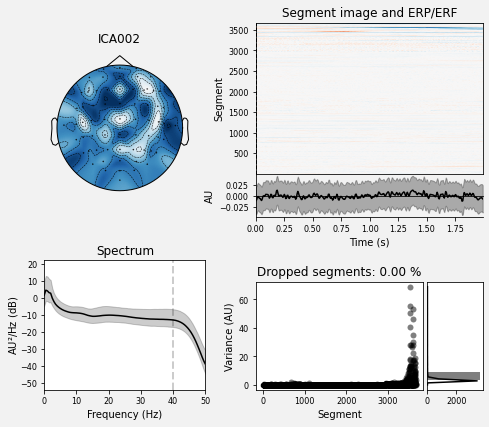

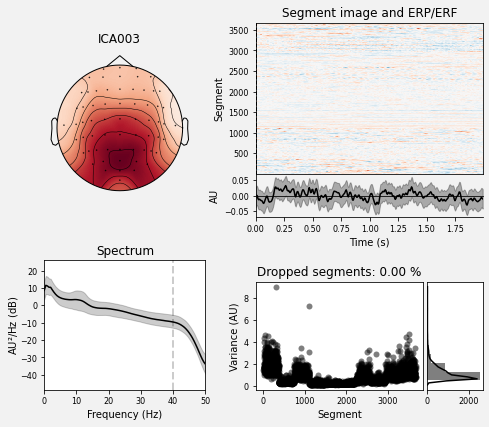

Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 3 ICA components
    Projecting back using 64 PCA components
ICA DONE ????
>>> Create Epochs.
Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
Not setting metadata
900 matching events found
No baseline correction applied
0 projection items activated
Loading data for 900 events and 641 original time points ...
0 bad epochs dropped


(array([[    672,       0,       1],
        [   2000,       0,       0],
        [   3328,       0,       0],
        ...,
        [1183280,       0,       1],
        [1184592,       0,       0],
        [1185904,       0,       0]]),
 {'T1': 0, 'T2': 1})

In [3]:
# home directory + datasets folder
#path = '/content/drive/MyDrive/MNE-eegbci-data/files/eegmmidb/'
path = ''
base_url = 'https://physionet.org/files/eegmmidb/'
# subjects = [1]
runs = [3, 4, 7, 8, 11, 12]
subjects = [i for i in range(1, 11)]
#subjects = [1]
# runs = [6,10,14]

eeg = EEG(path, base_url, subjects, runs)
raw=eeg.data_to_raw()
# apply filter
freq = (0.05, 40.)
raw=eeg.filter(freq=freq)
raw=eeg.raw_ica()
eeg.create_epochs()

In [5]:
X, y = eeg.get_X_y()

print(X.shape, y.shape)

X = X[:, np.newaxis,:,:]
X.shape

(900, 64, 641) (900,)


(900, 1, 64, 641)

In [6]:
#X2 = X[:, :, 7:8, :] 
#print(X2.shape)

#X3= X[:, :, 13:14, :]
#print(X3.shape)

#X4 = np.concatenate((X2,X3), axis=2)
#print(X4.shape)
#X = X4

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(X_train.shape, y_train.shape)

(720, 1, 64, 641) (720,)


In [8]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

batch_size = 32

def create_dataloader(X, y, batch_size):
    X_tensor = torch.tensor(X).float()
    y_tensor = torch.tensor(y).long()
    dataset_tensor = TensorDataset(X_tensor, y_tensor)
    dl = torch.utils.data.DataLoader(dataset_tensor, batch_size=batch_size, shuffle=True)
    return dl
train_loader = create_dataloader(X_train, y_train, batch_size=batch_size)
test_loader = create_dataloader(X_test, y_test, batch_size=batch_size)

In [9]:
for i, (images, label) in enumerate(train_loader):
    print(images.shape)
    break

torch.Size([32, 1, 64, 641])


In [10]:
#set gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [16]:
# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        #using sequential helps bind multiple operations together
        self.layer1 = nn.Sequential(
            #in_channel = 1
            #out_channel = 16
            #padding = (kernel_size - 1) / 2 = 2
            nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        #after layer 1 will be of shape [32, 16, 32, 80]
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        #after layer 2 will be of shape [100, 32, 16, 40]
        self.fc = nn.Linear(655360, 2)
        self.drop_out = nn.Dropout(0.5)  #zeroed 0.2% data
        #after fc will be of shape [100, 10]
        
    def forward(self, x):
        #x shape: [batch, in_channel, img_width, img_height]
        #[32, 1, 64, 161]
        out = self.layer1(x)
        out = self.drop_out(out)
        #after layer 1: shape: [32, 16, 32, 80]
        #out = self.layer2(out)
        #out = self.drop_out(out)
        #after layer 2: shape: [100, 32, 16, 40]
        out = out.reshape(out.size(0), -1)   #can also use .view()
        #after squeezing: shape: [32, 20480]
        #we squeeze so that it can be inputted into the fc layer
        #print(out.shape)
        out = self.fc(out)
        #after fc layer: shape: [32, 2]
        return out

In [24]:
net = ConvNet().cuda(3)

In [25]:
# Loss and optimizer
optimizer = optim.Adam(net.parameters(), lr=0.00001)
criterion = nn.CrossEntropyLoss()

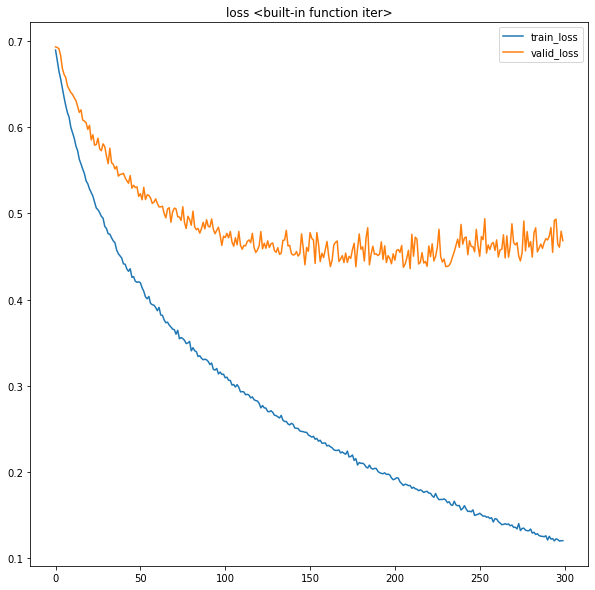

Epoch 300/300, Tr Loss: 0.1206, Tr Acc: 98.7500, Val Loss: 0.4684, Val Acc: 78.8889


In [22]:
# Train the model
num_epochs = 300

train_loss = []
valid_loss = []
train_accuracy = []
valid_accuracy = []
for epoch in range(num_epochs):
    iter_loss = 0.0
    correct = 0
    iterations = 0
    
    net.train()
    
    for i, (items, classes) in enumerate(train_loader):
        items = Variable(items)
        classes = Variable(classes)
        
        if cuda.is_available():
            items = items.cuda(3)
            classes = classes.cuda(3)
        
        optimizer.zero_grad()
        outputs = net(items)
        loss = criterion(outputs, classes)
        #print(outputs)
        iter_loss += loss.item()
        loss.backward()
        optimizer.step()
        #print(loss)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum()
        iterations += 1

    train_loss.append(iter_loss/iterations)
    
    train_accuracy.append((100 * correct.float() / len(train_loader.dataset)))
    
    loss = 0.0
    correct = 0
    iterations = 0
    net.eval()
    
    for i, (items, classes) in enumerate(test_loader):
        items = Variable(items)
        classes = Variable(classes)
        
        if cuda.is_available():
            items = items.cuda(3)
            classes = classes.cuda(3)
        
        outputs = net(items)
        loss += criterion(outputs, classes).item()
        
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum()
        
        iterations += 1

    valid_loss.append(loss/iterations)
    correct_scalar = np.array([correct.clone().cpu()])[0]
    valid_accuracy.append(correct_scalar / len(test_loader.dataset) * 100.0)
    do_plot(train_loss, valid_loss,)
    print ('Epoch %d/%d, Tr Loss: %.4f, Tr Acc: %.4f, Val Loss: %.4f, Val Acc: %.4f'
               %(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], valid_loss[-1], valid_accuracy[-1]))

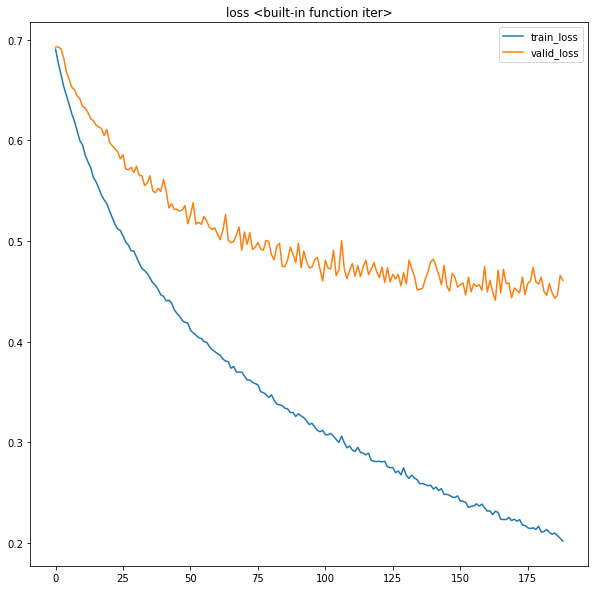

Epoch 189/200, Tr Loss: 0.2019, Tr Acc: 96.1111, Val Loss: 0.4608, Val Acc: 83.3333


In [ ]:
# Train the model
num_epochs = 200

train_loss = []
valid_loss = []
train_accuracy = []
valid_accuracy = []
for epoch in range(num_epochs):
    iter_loss = 0.0
    correct = 0
    iterations = 0
    
    net.train()
    
    for i, (items, classes) in enumerate(train_loader):
        items = Variable(items)
        classes = Variable(classes)
        
        if cuda.is_available():
            items = items.cuda(3)
            classes = classes.cuda(3)
        
        optimizer.zero_grad()
        outputs = net(items)
        loss = criterion(outputs, classes)
        #print(outputs)
        iter_loss += loss.item()
        loss.backward()
        optimizer.step()
        #print(loss)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum()
        iterations += 1

    train_loss.append(iter_loss/iterations)
    
    train_accuracy.append((100 * correct.float() / len(train_loader.dataset)))
    
    loss = 0.0
    correct = 0
    iterations = 0
    net.eval()
    
    for i, (items, classes) in enumerate(test_loader):
        items = Variable(items)
        classes = Variable(classes)
        
        if cuda.is_available():
            items = items.cuda(3)
            classes = classes.cuda(3)
        
        outputs = net(items)
        loss += criterion(outputs, classes).item()
        
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum()
        
        iterations += 1

    valid_loss.append(loss/iterations)
    correct_scalar = np.array([correct.clone().cpu()])[0]
    valid_accuracy.append(correct_scalar / len(test_loader.dataset) * 100.0)
    do_plot(train_loss, valid_loss,)
    print ('Epoch %d/%d, Tr Loss: %.4f, Tr Acc: %.4f, Val Loss: %.4f, Val Acc: %.4f'
               %(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], valid_loss[-1], valid_accuracy[-1]))